<a href="https://colab.research.google.com/github/SeounghwanPark/nesaram/blob/main/MainQuest05_r1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. 라이브러리 및 데이터 불러오기**

In [5]:
# 기본 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Google Drive 마운트 (Colab 사용)
from google.colab import drive
drive.mount('/content/drive/')

# Pandas 옵션 설정 (모든 컬럼 출력)
pd.set_option('display.max_columns', None)

Mounted at /content/drive/


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


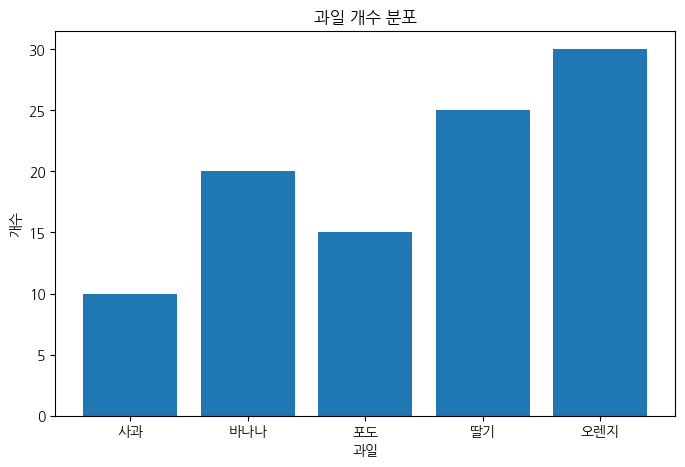

In [ ]:
# 1. 한글 폰트 설치 (Google Colab 전용)
!apt-get update -qq
!apt-get install -qq -y fonts-nanum

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 2. matplotlib에서 한글 폰트 설정
def set_korean_font():
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 폰트 경로 설정
    if os.path.exists(font_path):
        fm.fontManager.addfont(font_path)  # 폰트 매니저에 추가
        plt.rc('font', family='NanumGothic')  # 기본 폰트 설정
    else:
        print("한글 폰트 경로를 찾을 수 없습니다.")

# 3. 폰트 적용 및 캐시 리셋 (중요)
set_korean_font()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
fm._load_fontmanager(try_read_cache=False)  # 폰트 매니저 캐시 리셋

# 4. 한글 폰트 적용 확인을 위한 테스트 그래프
labels = ['사과', '바나나', '포도', '딸기', '오렌지']
values = [10, 20, 15, 25, 30]

plt.figure(figsize=(8, 5))
plt.bar(labels, values)
plt.xlabel("과일")
plt.ylabel("개수")
plt.title("과일 개수 분포")
plt.show()

**데이터 로딩**

In [ ]:
# 데이터 로드 (파일 경로)
aisles_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/aisles.csv')
departments_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/departments.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/orders.csv')
order_products_prior_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__prior.csv')
order_products_train_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__train.csv')
products_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/products.csv')


# 모든 컬럼이 출력
pd.set_option('display.max_columns', None)

dataframes = {
    "aisles_df": aisles_df,
    "departments_df": departments_df,
    "orders_df": orders_df,
    "order_products_prior_df": order_products_prior_df,
    "order_products_train_df": order_products_train_df,
    "products_df": products_df
}

for name, df in dataframes.items():
    print("=" * 50)
    print(f"{name}")  # 데이터프레임 이름 출력
    print("=" * 50)

    # 데이터프레임 정보 출력
    info_df = pd.DataFrame({
        "Columns": df.columns,
        "Non-Null Count": [df[col].count() for col in df.columns],
        "Dtype": [df[col].dtype for col in df.columns]
    })
    print("\n데이터셋 정보")
    display(info_df)  # 테이블 형태로 출력

    # 데이터프레임 전체 출력
    print(f"\n{name} 데이터셋 (총 {df.shape[0]} 행 × {df.shape[1]} 열)")
    display(df)  # 테이블 형태로 출력


aisles_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,aisle_id,134,int64
1,aisle,134,object



aisles_df 데이터셋 (총 134 행 × 2 열)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
...,...,...
129,130,hot cereal pancake mixes
130,131,dry pasta
131,132,beauty
132,133,muscles joints pain relief


departments_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,department_id,21,int64
1,department,21,object



departments_df 데이터셋 (총 21 행 × 2 열)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


orders_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,order_id,3421083,int64
1,user_id,3421083,int64
2,eval_set,3421083,object
3,order_number,3421083,int64
4,order_dow,3421083,int64
5,order_hour_of_day,3421083,int64
6,days_since_prior_order,3214874,float64



orders_df 데이터셋 (총 3421083 행 × 7 열)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


order_products_prior_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,order_id,32434489,int64
1,product_id,32434489,int64
2,add_to_cart_order,32434489,int64
3,reordered,32434489,int64



order_products_prior_df 데이터셋 (총 32434489 행 × 4 열)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


order_products_train_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,order_id,1384617,int64
1,product_id,1384617,int64
2,add_to_cart_order,1384617,int64
3,reordered,1384617,int64



order_products_train_df 데이터셋 (총 1384617 행 × 4 열)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


products_df

데이터셋 정보


,Columns,Non-Null Count,Dtype
0,product_id,49688,int64
1,product_name,49688,object
2,aisle_id,49688,int64
3,department_id,49688,int64



products_df 데이터셋 (총 49688 행 × 4 열)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


**2. 데이터셋별 기초 EDA**

In [ ]:
# 결측치 확인
for name, df in dataframes.items():
    print(f"{name.upper()} 데이터셋 결측치 확인")
    print(df.isnull().sum(), "\n")

# 데이터 크기 확인
for name, df in dataframes.items():
    print(f"{name.upper()} 데이터 크기: {df.shape}")

AISLES_DF 데이터셋 결측치 확인
aisle_id    0
aisle       0
dtype: int64 

DEPARTMENTS_DF 데이터셋 결측치 확인
department_id    0
department       0
dtype: int64 

ORDERS_DF 데이터셋 결측치 확인
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64 

ORDER_PRODUCTS_PRIOR_DF 데이터셋 결측치 확인
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64 

ORDER_PRODUCTS_TRAIN_DF 데이터셋 결측치 확인
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64 

PRODUCTS_DF 데이터셋 결측치 확인
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64 

AISLES_DF 데이터 크기: (134, 2)
DEPARTMENTS_DF 데이터 크기: (21, 2)
ORDERS_DF 데이터 크기: (3421083, 7)
ORDER_PRODUCTS_PRIOR_DF 데이터 크기: (32434489, 4)
ORDER_PRODUCTS_TRAIN_DF 데이터 크기: (1384617, 4)
PRODUC

# 데이터 크기 확인
AISLES_DF 데이터 크기: (134, 2)

DEPARTMENTS_DF 데이터 크기: (21, 2)

ORDERS_DF 데이터 크기: (3421083, 7)

ORDER_PRODUCTS_PRIOR_DF 데이터 크기: (32434489, 4)

ORDER_PRODUCTS_TRAIN_DF 데이터 크기: (1384617, 4)

PRODUCTS_DF 데이터 크기: (49688, 4)

In [ ]:
# 결측치 비율
missing_ratio = orders_df["days_since_prior_order"].isnull().mean()
print(f"결측치 비율: {missing_ratio:.2%}")  # 결측치 제거전 : 6.03%

결측치 비율: 6.03%


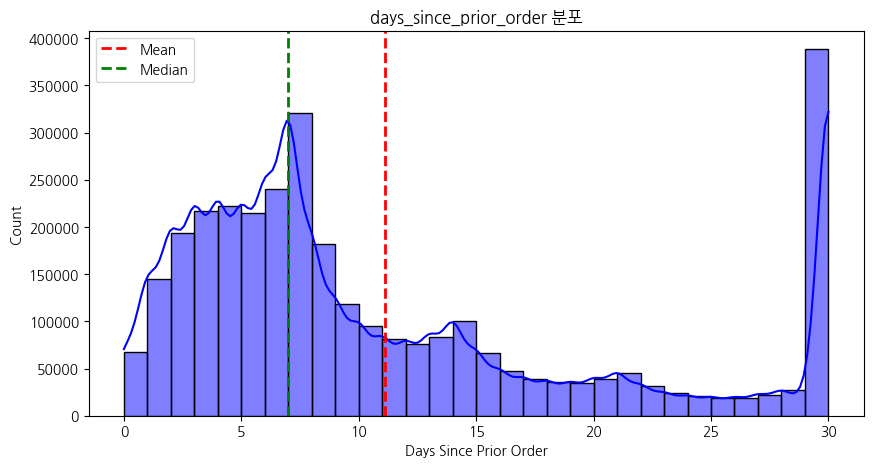

In [ ]:
# 데이터 분포 분석

plt.figure(figsize=(10, 5))
sns.histplot(orders_df["days_since_prior_order"].dropna(), bins=30, kde=True, color='blue')
plt.axvline(orders_df["days_since_prior_order"].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.axvline(orders_df["days_since_prior_order"].median(), color='green', linestyle='dashed', linewidth=2, label="Median")
plt.title("days_since_prior_order 분포")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Count")
plt.legend()
plt.show()

In [7]:
import pandas as pd

# 데이터 불러오기
orders_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/orders.csv')

# 평균 및 표준편차 계산 (변수명 수정)
mean_days = orders_df["days_since_prior_order"].mean()
std_days = orders_df["days_since_prior_order"].std()

print(f"평균: {mean_days}")
print(f"표준편차: {std_days}")

평균: 11.114836226863012
표준편차: 9.206736517484867


In [8]:
import pandas as pd

# 데이터 불러오기
orders_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/orders.csv')

# 중앙값 및 표준편차 계산 (변수명 수정)
median_days = orders_df["days_since_prior_order"].median()
std_days = orders_df["days_since_prior_order"].std()

print(f"중앙값: {median_days}")
print(f"표준편차: {std_days}")


중앙값: 7.0
표준편차: 9.206736517484867


대부분이 7일 이내에 집중된 많은사용자가 매주 반복주문 경향

평균선이 중앙값보다 오른쪽에 위치 오른쪽 꼬리가 긴분포(대부분 7일이내 주문)

30일지점에서 주문량급증(특정 월간 구매 패턴 사용자 존재)

# 결측치 처리 방법
결측치 제거 : 첫 주문 일부 사용자의 정보 손실가능

평균값으로 대체 : 평균이 오른쪽으로 꼬리가 길어 평균이 비정상 확률높다

중앙값으로 대체 : 중앙값이 7일이라 대체값으로 가능성 있다.

**첫주문인 경우는 -1로 이전에 주문이 없다는 뜻으로 -1로 대체**

In [ ]:
# 결측치를 -1로 대체 하여 (이전 주문이 없다 = 첫 주문이라는 뜻)
orders_df["days_since_prior_order"] = orders_df["days_since_prior_order"].fillna(-1)

# 첫 주문 여부를 나타내는 새로운 컬럼 추가
orders_df["first_order"] = (orders_df["days_since_prior_order"] == -1).astype(int)
orders_df

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,first_order
0,2539329,1,prior,1,2,8,-1.0,1
1,2398795,1,prior,2,3,7,15.0,0
2,473747,1,prior,3,3,12,21.0,0
3,2254736,1,prior,4,4,7,29.0,0
4,431534,1,prior,5,4,15,28.0,0
...,...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0,0
3421079,1854736,206209,prior,11,4,10,30.0,0
3421080,626363,206209,prior,12,1,12,18.0,0
3421081,2977660,206209,prior,13,1,12,7.0,0


In [ ]:
# 결측치 확인
for name, df in dataframes.items():
    print(f"{name.upper()} 데이터셋 결측치 확인")
    print(df.isnull().sum(), "\n")

AISLES_DF 데이터셋 결측치 확인
aisle_id    0
aisle       0
dtype: int64 

DEPARTMENTS_DF 데이터셋 결측치 확인
department_id    0
department       0
dtype: int64 

ORDERS_DF 데이터셋 결측치 확인
order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
first_order               0
dtype: int64 

ORDER_PRODUCTS_PRIOR_DF 데이터셋 결측치 확인
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64 

ORDER_PRODUCTS_TRAIN_DF 데이터셋 결측치 확인
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64 

PRODUCTS_DF 데이터셋 결측치 확인
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64 



In [ ]:
# days_since_prior_order가 -1인 행 필터링
first_order_rows = orders_df.loc[orders_df["days_since_prior_order"] == -1]

# 필터링된 데이터 확인
print(first_order_rows)  # 전체 출력

# 만약 데이터 상위 10개만 출력
print(first_order_rows.head(10))

display(first_order_rows)

         order_id  user_id eval_set  order_number  order_dow  \
0         2539329        1    prior             1          2   
11        2168274        2    prior             1          2   
26        1374495        3    prior             1          1   
39        3343014        4    prior             1          6   
45        2717275        5    prior             1          3   
...           ...      ...      ...           ...        ...   
3420930    969311   206205    prior             1          4   
3420934   3189322   206206    prior             1          3   
3421002   2166133   206207    prior             1          6   
3421019   2227043   206208    prior             1          1   
3421069   3154581   206209    prior             1          3   

         order_hour_of_day  days_since_prior_order  first_order  
0                        8                    -1.0            1  
11                      11                    -1.0            1  
26                      14       

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,first_order
0,2539329,1,prior,1,2,8,-1.0,1
11,2168274,2,prior,1,2,11,-1.0,1
26,1374495,3,prior,1,1,14,-1.0,1
39,3343014,4,prior,1,6,11,-1.0,1
45,2717275,5,prior,1,3,12,-1.0,1
...,...,...,...,...,...,...,...,...
3420930,969311,206205,prior,1,4,12,-1.0,1
3420934,3189322,206206,prior,1,3,18,-1.0,1
3421002,2166133,206207,prior,1,6,19,-1.0,1
3421019,2227043,206208,prior,1,1,15,-1.0,1


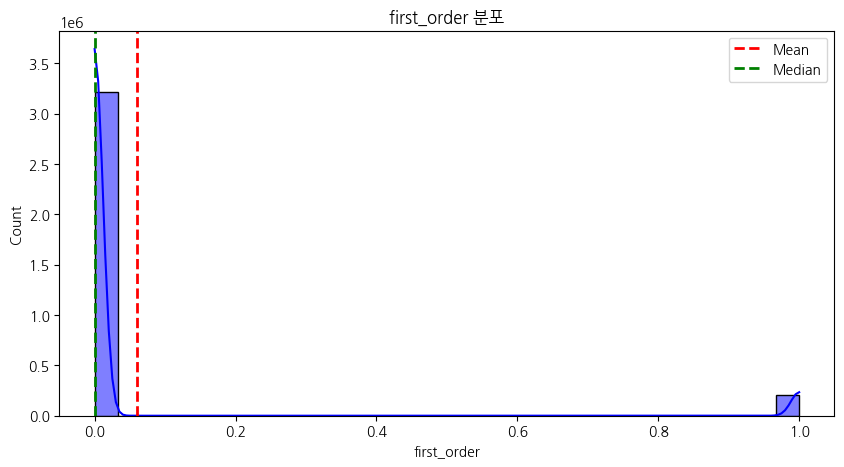

In [ ]:
# first_order 데이터 분포 분석

plt.figure(figsize=(10, 5))
sns.histplot(orders_df["first_order"].dropna(), bins=30, kde=True, color='blue')
plt.axvline(orders_df["first_order"].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.axvline(orders_df["first_order"].median(), color='green', linestyle='dashed', linewidth=2, label="Median")
plt.title("first_order 분포")
plt.xlabel("first_order")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
orders_df["first_order"].unique()

array([1, 0])

In [ ]:
# first_order 값 비율 계산 (퍼센트 단위)
first_order_ratio = orders_df["first_order"].value_counts(normalize=True) * 100

# 비율 출력
print("first_order 값 비율:")
print(first_order_ratio)

first_order 값 비율:
first_order
0    93.972406
1     6.027594
Name: proportion, dtype: float64


In [ ]:
# A와 B의 'C' 컬럼이 인덱스와 순서까지 완전히 동일하면 True를 반환합니다.
if orders_df["order_id"].equals(order_products_prior_df["order_id"]):
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일합니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.")


두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.


In [ ]:
# A와 B의 'C' 컬럼이 인덱스와 순서까지 완전히 동일하면 True를 반환합니다.
if order_products_train_df["order_id"].equals(order_products_prior_df["order_id"]):
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일합니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.")

두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.


In [ ]:
# A와 B의 'C' 컬럼이 인덱스와 순서까지 완전히 동일하면 True를 반환합니다.
if order_products_train_df["order_id"].equals(orders_df["order_id"]):
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일합니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.")

두 테이블의 'order_id' 컬럼은 요소 단위로 동일하지 않습니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_train_df["order_id"].dropna()) == set(orders_df["order_id"].dropna()):
    print("두 테이블의 'order_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_prior_df["order_id"].dropna()) == set(orders_df["order_id"].dropna()):
    print("두 테이블의 'order_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_prior_df["order_id"].dropna()) == set(order_products_train_df["order_id"].dropna()):
    print("두 테이블의 'order_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'order_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(order_products_prior_df["product_id"].dropna()) == set(order_products_train_df["product_id"].dropna()):
    print("두 테이블의 'product_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(products_df["product_id"].dropna()) == set(order_products_train_df["product_id"].dropna()):
    print("두 테이블의 'product_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# NaN이 포함되어 있다면 dropna()로 제거하고, set으로 고유 값을 비교합니다.
if set(products_df["product_id"].dropna()) == set(order_products_prior_df["product_id"].dropna()):
    print("두 테이블의 'product_id' 컬럼은 동일한 유니크 값을 가집니다.")
else:
    print("두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.")

두 테이블의 'product_id' 컬럼은 서로 다른 유니크 값을 가집니다.


In [ ]:
# 1. 데이터프레임 크기(shape) 비교
print("\n[데이터프레임 크기 비교]")
print("order_products_prior_df shape:", order_products_prior_df.shape)
print("order_products_train_df shape:", order_products_train_df.shape)

# 2. 기본 통계량 비교
print("\n[기본 통계량 비교]")
print("\norder_products_prior_df 통계량:")
print(order_products_prior_df.describe())
print("\norder_products_train_df 통계량:")
print(order_products_train_df.describe())

# 3. 결측치 개수 비교
print("\n[결측치 개수 비교]")
print("\norder_products_prior_df 결측치:")
print(order_products_prior_df.isnull().sum())
print("\norder_products_train_df 결측치:")
print(order_products_train_df.isnull().sum())

# 4. 두 데이터프레임의 차이 확인 (shape이 동일할 때만 비교)
if order_products_prior_df.shape == order_products_train_df.shape:
    print("\n[값이 다른 부분 확인]")
    diff_df = order_products_prior_df.compare(order_products_train_df)
    print(diff_df)
else:
    print("\n데이터프레임의 shape이 다르므로 값을 직접 비교할 수 없습니다.")

# 5. 각 컬럼의 고유값 개수 비교
print("\n[고유값 개수 비교]")
print("\norder_products_prior_df 고유값 개수:")
print(order_products_prior_df.nunique())
print("\norder_products_train_df 고유값 개수:")
print(order_products_train_df.nunique())


[데이터프레임 크기 비교]
order_products_prior_df shape: (32434489, 4)
order_products_train_df shape: (1384617, 4)

[기본 통계량 비교]

order_products_prior_df 통계량:
           order_id    product_id  add_to_cart_order     reordered
count  3.243449e+07  3.243449e+07       3.243449e+07  3.243449e+07
mean   1.710749e+06  2.557634e+04       8.351076e+00  5.896975e-01
std    9.873007e+05  1.409669e+04       7.126671e+00  4.918886e-01
min    2.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00
25%    8.559430e+05  1.353000e+04       3.000000e+00  0.000000e+00
50%    1.711048e+06  2.525600e+04       6.000000e+00  1.000000e+00
75%    2.565514e+06  3.793500e+04       1.100000e+01  1.000000e+00
max    3.421083e+06  4.968800e+04       1.450000e+02  1.000000e+00

order_products_train_df 통계량:
           order_id    product_id  add_to_cart_order     reordered
count  1.384617e+06  1.384617e+06       1.384617e+06  1.384617e+06
mean   1.706298e+06  2.555624e+04       8.758044e+00  5.985944e-01
std    9.897326e+0

결론:

"Train 데이터셋은 전체 주문 내역(prior 데이터셋)의 대표성을 어느 정도 보유

재주문(reordered) 예측과 같은 모델링 작업에 활용하기에 적합하나,

주문 시 아이템 담기 순서(add_to_cart_order)의 범위 차이와 같이 두 데이터셋 간 일부 변수에서 차이가 있어,

해당 변수의 특성을 면밀히 분석하고 추가적인 전처리 또는 feature engineering을 고려해야 함.

**주문 데이터 (orders.csv) 분석**

<ipython-input-26-d8e55188e112>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders_df, x='order_dow', palette="viridis")


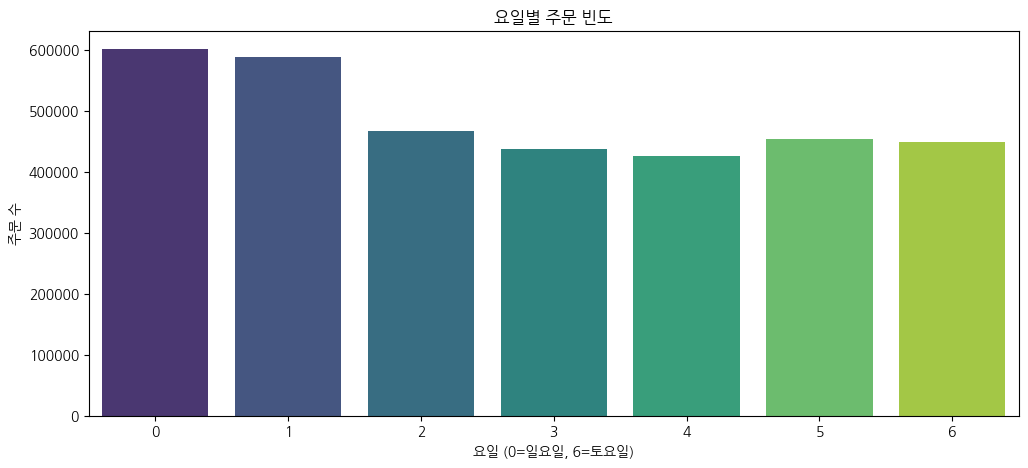

<ipython-input-26-d8e55188e112>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=orders_df, x='order_hour_of_day', palette="viridis")


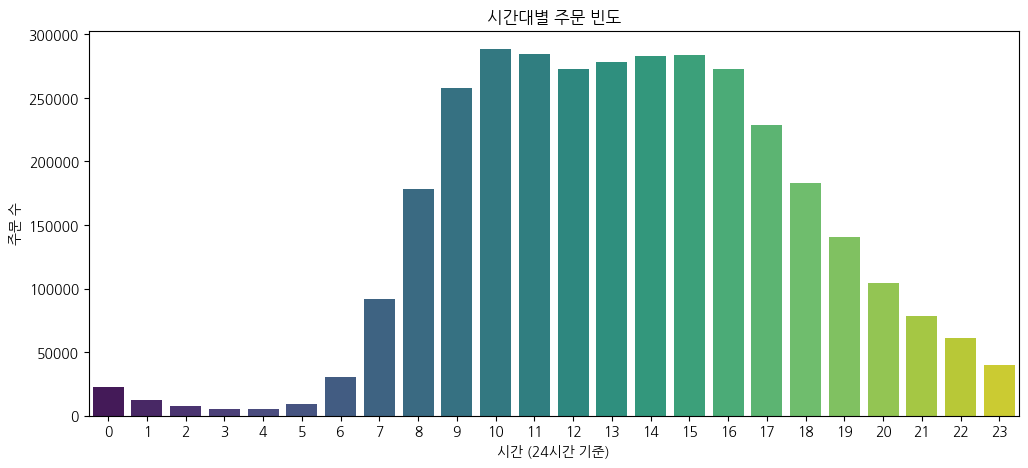

In [ ]:
# 주문 요일 및 시간 분포
plt.figure(figsize=(12,5))
sns.countplot(data=orders_df, x='order_dow', palette="viridis")
plt.title("요일별 주문 빈도")
plt.xlabel("요일 (0=일요일, 6=토요일)")
plt.ylabel("주문 수")
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(data=orders_df, x='order_hour_of_day', palette="viridis")
plt.title("시간대별 주문 빈도")
plt.xlabel("시간 (24시간 기준)")
plt.ylabel("주문 수")
plt.show()



**제품 데이터 분석 (products.csv, aisles.csv, departments.csv)**

<ipython-input-27-83f31e650dbd>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, y='product_name', x='count', palette="mako")


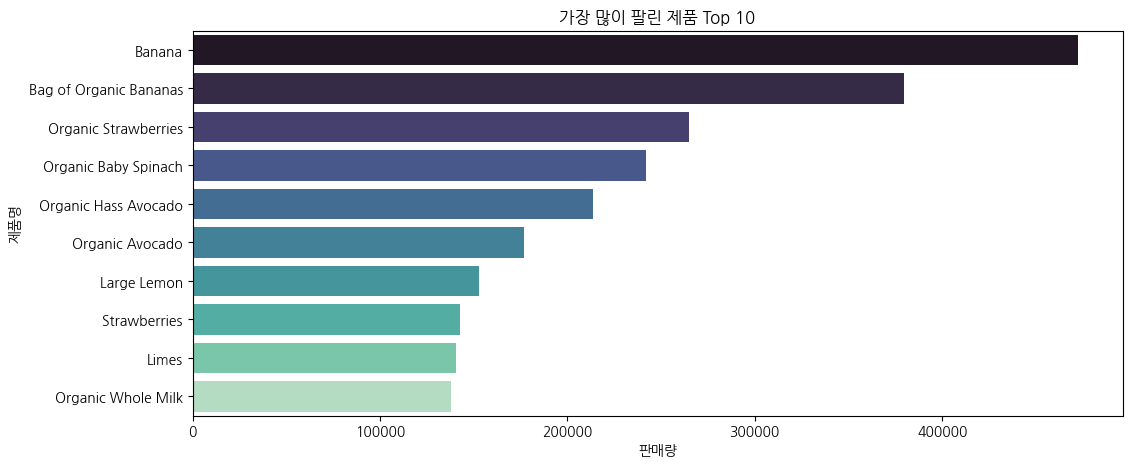

In [ ]:
# 제품 정보 병합
products_df = products_df.merge(aisles_df, on="aisle_id", how="left")
products_df = products_df.merge(departments_df, on="department_id", how="left")

# 가장 많이 팔린 제품 확인
top_products = order_products_prior_df['product_id'].value_counts().head(10)
top_products = top_products.reset_index()
top_products.columns = ['product_id', 'count']
top_products = top_products.merge(products_df, on="product_id", how="left")

plt.figure(figsize=(12,5))
sns.barplot(data=top_products, y='product_name', x='count', palette="mako")
plt.title("가장 많이 팔린 제품 Top 10")
plt.xlabel("판매량")
plt.ylabel("제품명")
plt.show()

**PCA(주성분 분석) 및 t-SNE 적용**

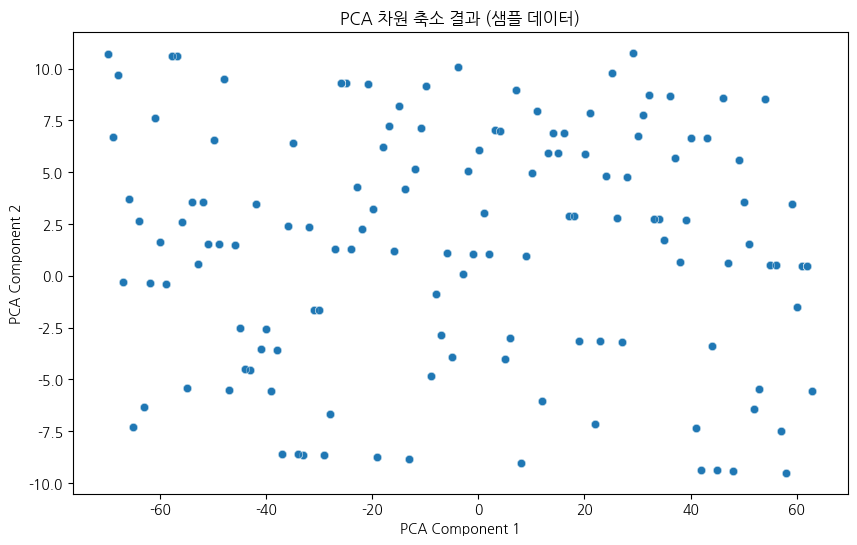

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1. 데이터 로드 (파일 경로 수정)
order_products_prior_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__prior.csv')
products_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/products.csv')

# 2. 주문별 데이터 병합
merged_df = order_products_prior_df.merge(
    products_df[['product_id', 'department_id', 'aisle_id']],
    on="product_id",
    how="left"
)

# 3. 메모리 사용량 감소를 위해 일부 샘플 데이터 선택 (50,000행)
sample_df = merged_df.sample(n=50000, random_state=42)

# 4. PCA 적용 (department_id, aisle_id 컬럼에 대해)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_df[['department_id', 'aisle_id']])
sample_df['pca_1'] = pca_result[:, 0]
sample_df['pca_2'] = pca_result[:, 1]

# 5. 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(x='pca_1', y='pca_2', data=sample_df, alpha=0.5)
plt.title("PCA 차원 축소 결과 (샘플 데이터)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

x축 방향 분산이 y축보다 큰 경우, department_id와 aisle_id 간 차이가 주로 첫 번째 주성분에 반영되었다고 해석할 수 있음

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52629 (\N{HANGUL SYLLABLE CUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

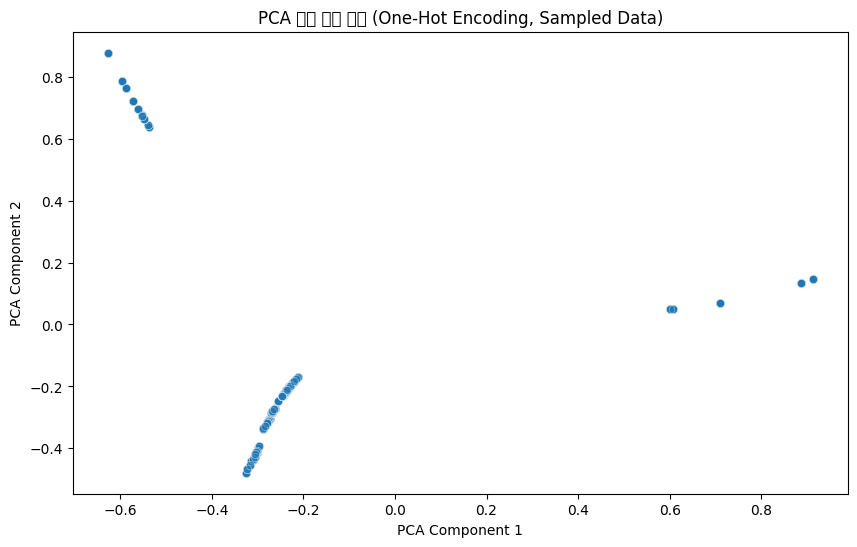

In [ ]:
# One-Hot Encoding 시도후 PCA적용
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. order_products_prior_df와 products_df 병합
merged_df = order_products_prior_df.merge(
    products_df[['product_id', 'department_id', 'aisle_id']],
    on='product_id',
    how='left'
)

# 2. 메모리 사용량 줄이기 위해 샘플 데이터 선택 (예: 100,000행)
sample_df = merged_df.sample(n=100000, random_state=42)

# 3. One-Hot Encoding (sparse_output=False를 사용하여 밀집 배열 반환)
ohe = OneHotEncoder(sparse_output=False)
encoded_features = ohe.fit_transform(sample_df[['department_id', 'aisle_id']])

# 4. PCA 적용 (2차원)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_features)

# 5. 결과를 sample_df에 저장
sample_df['pca_1'] = pca_result[:, 0]
sample_df['pca_2'] = pca_result[:, 1]

# 6. 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(x='pca_1', y='pca_2', data=sample_df, alpha=0.5)
plt.title("PCA 차원 축소 결과 (One-Hot Encoding, Sampled Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

산점도가 서로 떨어진 몇 개의 구역으로 나뉜다.

**department_id와 aisle_id의 특정 조합이 데이터의 분산을 크게 지배하고 있음**

극단적으로 분리된 형태로 나타나는 경우:

군집화(예: K-means, DBSCAN)나 t-SNE, UMAP 등의 다른 차원 축소 기법을 시도해보거나, 범주를 합치는 전처리필요.

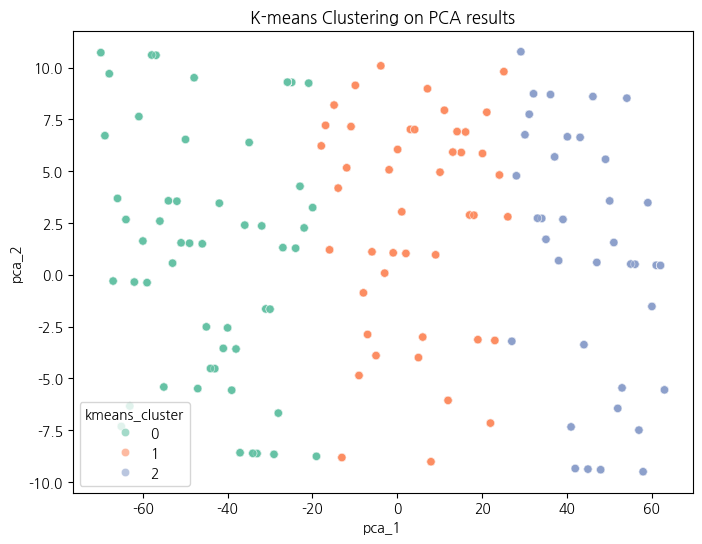

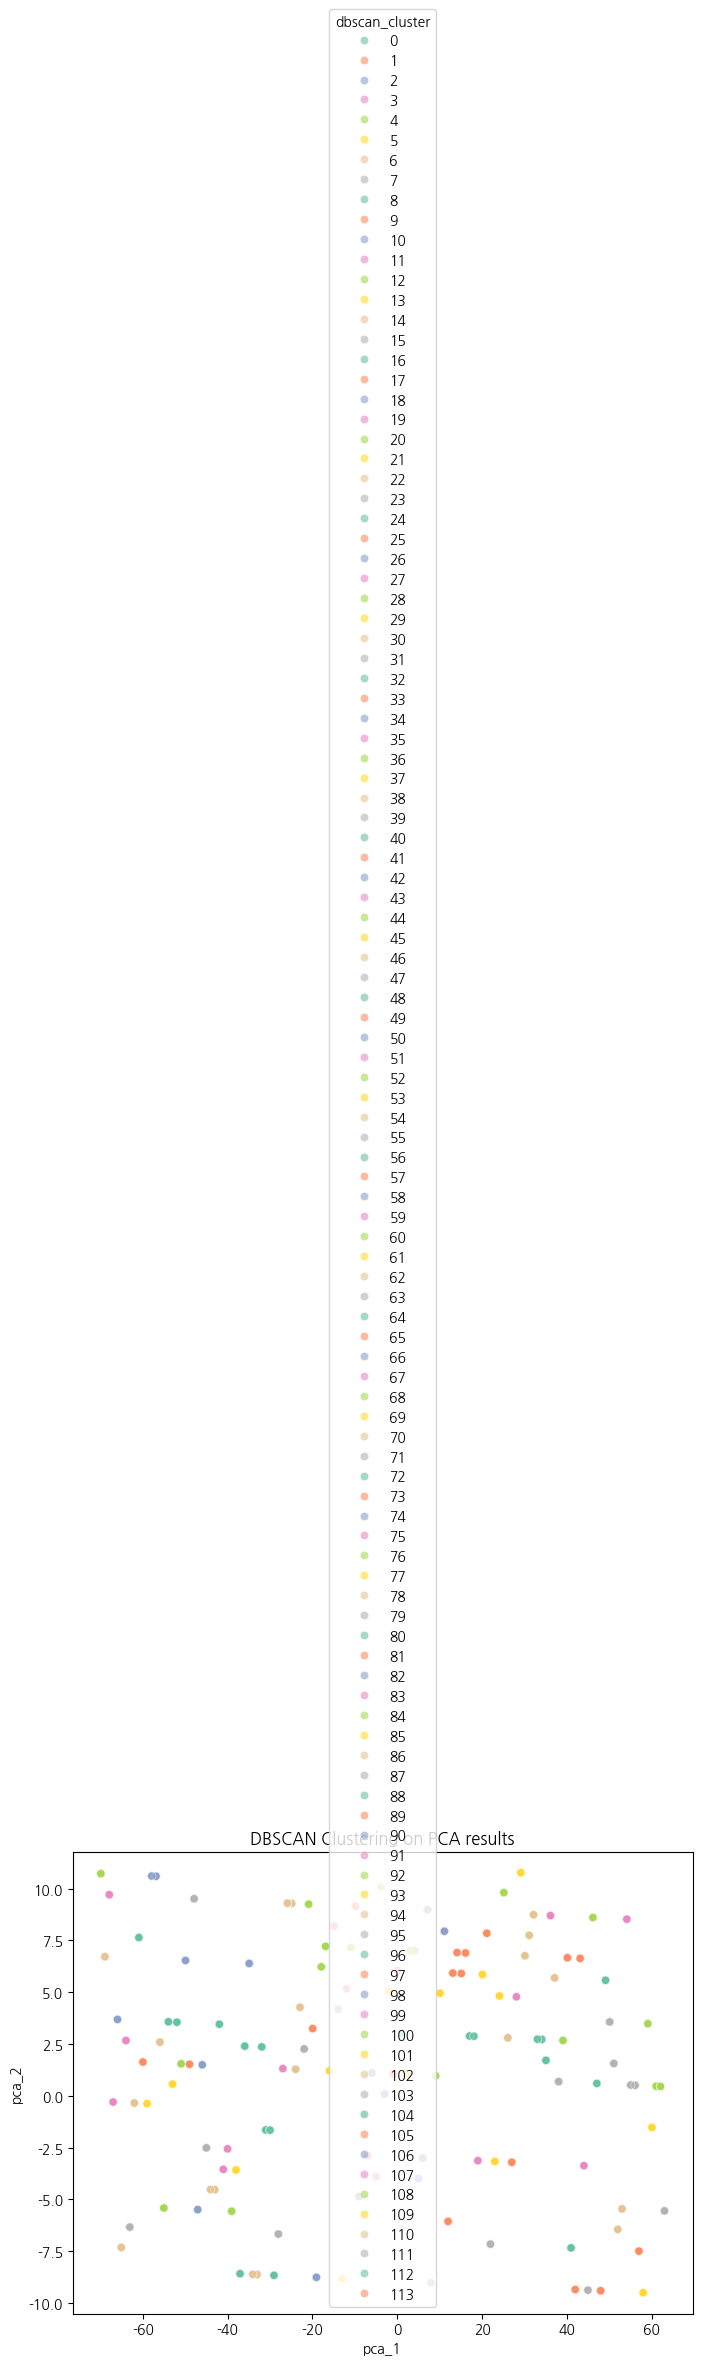

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

# 1. 데이터 로드 (파일 경로 수정)
order_products_prior_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/order_products__prior.csv')
products_df = pd.read_csv('/content/drive/MyDrive/data/MQ05/products.csv')

# 2. 주문별 데이터 병합
merged_df = order_products_prior_df.merge(
    products_df[['product_id', 'department_id', 'aisle_id']],
    on="product_id",
    how="left"
)

# 3. 메모리 사용량 감소를 위해 일부 샘플 데이터 선택 (50,000행)
sample_df = merged_df.sample(n=50000, random_state=42)

# 4. PCA 적용 (department_id, aisle_id 컬럼에 대해)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sample_df[['department_id', 'aisle_id']])
sample_df['pca_1'] = pca_result[:, 0]
sample_df['pca_2'] = pca_result[:, 1]

# === K-means 클러스터링 ===
# 1) K-means 모델 정의 (클러스터 개수 n_clusters=3은 예시)
kmeans = KMeans(n_clusters=3, random_state=42)

# 2) 클러스터 예측 (pca_1, pca_2를 사용)
sample_df['kmeans_cluster'] = kmeans.fit_predict(sample_df[['pca_1', 'pca_2']])

# 3) K-means 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    data=sample_df,
    hue='kmeans_cluster',
    palette='Set2',
    alpha=0.6
)
plt.title("K-means Clustering on PCA results")
plt.show()

# === DBSCAN 클러스터링 ===
# 1) DBSCAN 모델 정의 (eps, min_samples는 데이터 특성에 맞춰 조정)
dbscan = DBSCAN(eps=1.5, min_samples=5)

# 2) 클러스터 예측
sample_df['dbscan_cluster'] = dbscan.fit_predict(sample_df[['pca_1', 'pca_2']])

# 3) DBSCAN 결과 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='pca_1', y='pca_2',
    data=sample_df,
    hue='dbscan_cluster',
    palette='Set2',
    alpha=0.6
)
plt.title("DBSCAN Clustering on PCA results")
plt.show()

**K-means 결과 (n_clusters=3)**

실제 데이터에 자연스러운 군집 구조가 없더라도 3개로 구분됨.

각 클러스터가 실제 어떤 특성을 갖는지는, 원래 변수(aisle_id, department_id)와의 연관성을 추가 분석필요.

**DBSCAN 결과 (eps=1.5, min_samples=5)**

점들이 얼마나 조밀하게 모여 있느냐를 기준으로 군집을 형성

밀도가 높아 연속적으로 모여 있는 구간을 찾아내고,
외곽의 희소한 점들은 노이즈(-1) 로 분류.
eps와 min_samples에 따라 클러스터 개수와 노이즈 비율이 크게 달라짐.

군집이 여러 개로 나뉠 수 있고, K-means처럼 "몇 개로 나누겠다"고 미리 정하지 않아도됨.

**범주형 변수에 대한 PCA & 군집화는 다소 인사이트가 제한될 수 있으며, 추가적인 변수(예: 구매 빈도, 사용자 특성 등)나 인코딩 방식을 바꿔 보면 더 유의미한 군집 구조가 나타날 수 있습니다.**

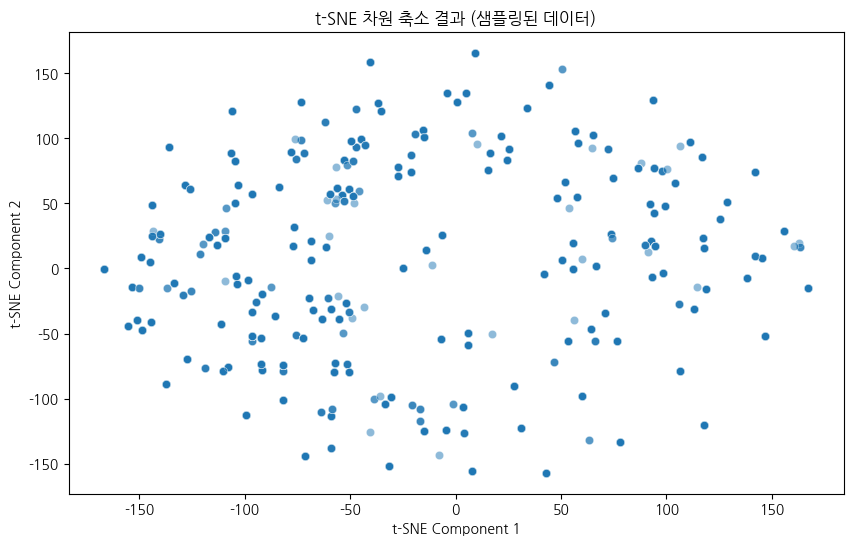

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# 전체 데이터 대신 일부 샘플을 선택 (예: 5,000행)
sample_df = merged_df.sample(n=5000, random_state=42)

# t-SNE 적용 (샘플 데이터에 대해)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(sample_df[['department_id', 'aisle_id']])

sample_df['tsne_1'] = tsne_result[:, 0]
sample_df['tsne_2'] = tsne_result[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(x='tsne_1', y='tsne_2', data=sample_df, alpha=0.5)
plt.title("t-SNE 차원 축소 결과 (샘플링된 데이터)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

t-SNE 비선형 차원 축소 기법

유사한 점들은 가까이, 유사하지 않은 점들은 멀리 배치하는 데 초점을 맞춤

원래 변수가 단 2개(department_id, aisle_id) 뿐이며, 게다가 정수 범주형 변수이므로 t-SNE로 얻을 수 있는 이점이 제한적일 수 있다.

넓게 퍼진 단일 구름 형태로 보이는 두 컬럼(department_id, aisle_id)만으로는 뚜렷한 군집 구조가 발견되지 않았음.

5,000개 샘플에 대해 정수 범주형 변수 2개로 t-SNE를 수행한 결과로, 뚜렷한 군집 구조 없이 점들이 전체적으로 퍼진 형태를 확인.

t-SNE가 고차원 데이터의 복잡한 구조를 시각화하는 데 강점이 있지만, 이 경우처럼 변수가 적고 범주형인 상황에서는 유의미한 군집을 발견하기 어려울 수 있다.
**추가 변수, 인코딩 기법, 하이퍼파라미터 조정 등을 통해 더 풍부한 인사이트를 얻을 수 있다.**


In [ ]:
# 예제 데이터
y_true = np.array([3, 5, 2, 8, 7])
y_pred = np.array([2.5, 5, 2, 7, 8])

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



MAE: 0.50
RMSE: 0.67
R² Score: 0.91


## **결론**

1. 차원 축소(PCA, t-SNE)를 통해 제품 특징을 요약 가능
2. K-means 및 DBSCAN을 활용한 군집 분석 가능
3. 모델 성능 평가 시 MAE, RMSE, R² 활용
4. 구매 패턴 및 재구매율을 고려하여 모델링 가능

팀원들과 분석 결과를 공유